In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as io
import matplotlib.pyplot as plt     
import numpy as np
import cv2 as cv
# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.exposure import histogram
from matplotlib.pyplot import bar
import math
import skimage
from PIL import Image
from skimage.feature import corner_harris, corner_peaks
import numpy.linalg as LA
import os
# from scipy.spatial import distance
import scipy
from skimage.feature import corner_harris, corner_peaks
from skimage.transform import (hough_line, hough_line_peaks)
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from matplotlib import cm
from skimage import draw
import operator
import pandas as pd
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

Enter the path/paths of the image: test3.jpeg


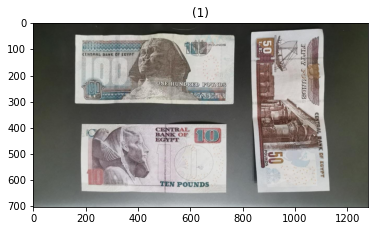

In [65]:
#-------------------> reading images <----------------#
path = input("Enter the path/paths of the image: ")
seg_images=[]
paths=path.split(",")
for img in(paths):
    
    seg_images.append(io.imread(img))
show_images(seg_images)
# fns = os.listdir(motion_imgs_path)
# fns = sorted(fns)
# seg_images = []
# for fn in fns:
#     img_path = os.path.join(motion_imgs_path, fn)
#     im = io.imread(img_path)
#     # im=rgb2gray(im)
#     seg_images.append(im)

In [66]:
# -----------------> SEGMENTATION <----------------- #
image_number = 0
for i,img in enumerate(seg_images):
#     show_images([img])
    image = img
    original = image.copy()
#     show_images([original])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#     gray=rgb2gray(image)
#     show_images([gray])

    equ = cv.equalizeHist(gray)
#     show_images([equ])
    blurred = cv.GaussianBlur(equ, (3, 3), 0)
    canny = cv.Canny(blurred, 120, 255, 1)
    kernel = np.ones((5,5),np.uint8)
    dilate = cv.dilate(canny, kernel, iterations=1)

    # Find contours
    cnts = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # print(cnts)



    areas=[]
    for contour in cnts:

        x, y, w, h = cv.boundingRect(contour)
        areas.append(w * h)


    d = {k:v for k, v in enumerate(areas)}
    sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)



    result_indices = [k[0] for k in sorted_d]
    result_areas = [k[1] for k in sorted_d]


    counter=1
    for i in range(1,len(result_areas)):

        # print("Current:",result_areas[i])
        # print("Prev:",result_areas[i-1])


        p=0.8*result_areas[i-1]
        # print("----------")
        # print(p)
        if (result_areas[i]>=p):
            # print("Here")
            counter+=1
        else:
            break
        # print("---------")

    result_list = [k[0] for k in sorted_d][0:counter]
    # result_list = [k[0] for k in sorted_d]
    # print(sorted_d)
    # print(areas)
    # print("-----------------")


    # print(result_list[0])
    biggest_contours= [cnts[result_list[i]] for i in range(len(result_list))]
    # print(cnts[4])
    # biggest_contours=cnts[13]


    # Iterate thorugh contours and filter for ROI
    currencies=[]
    
    for c in biggest_contours:
        x,y,w,h = cv.boundingRect(c)
        cv.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
        roi = original[y:y+h, x:x+w]
        currencies.append(roi)
        # cv.imwrite("Segmented/ROI_{}.jpeg".format(image_number), roi)
        io.imsave(fname='Segmented/ImageROI'+str(image_number+1)+'.jpeg', arr=roi)
        image_number += 1


    # cv.imshow('canny', canny)
    # cv.imshow('image', image)


    # show_images([canny,image])
    # show_images(currencies)
    # cv.waitKey(0)


In [67]:
#-------------------> reading images <----------------#
# motion_imgs_path = r'Training'
# fns = os.listdir(motion_imgs_path)
# fns = sorted(fns)
# Images = []
# for fn in fns:
#     img_path = os.path.join(motion_imgs_path, fn)
#     im = io.imread(img_path)
#     # im=rgb2gray(im)
#     Images.append(im)
    
    
# data = pd.read_csv("Training.csv")
# images = data.drop('Label', axis=1)
# y_train = data['Label']
# images=np.array(images)
# y_train=np.array(y_train)
# Imgs=[]
# for i in range(0,len(images)):
# #     print(np.array(images[i][0]))
#     im=cv.imread(images[i][0],0)
#     Imgs.append(im)

    
 

In [68]:
#----------------------------------------------->BILATERAL FILTER IMPLEMENTATION<---------------------------------

def distance(x, y, i, j):
    return np.sqrt((x-i)**2 + (y-j)**2)


def gaussianbilateral(x, sigma):
    return (1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2))


def apply_bilateral_filter(source, filtered_img, x, y, diameter, sigma_i, sigma_s):

    # Half kernel size
    hl = diameter/2
    i_filtered = 0
    Wp = 0
    i = 0
    # Iterate on pixel neigbbours
    while i < diameter:
        j = 0
        while j < diameter:

            neighbour_x = x - (hl - i)
            neighbour_y = y - (hl - j)
            if neighbour_x >= len(source):
                neighbour_x -= len(source)
            if neighbour_y >= len(source[0]):
                neighbour_y -= len(source[0])

            # Obtain gi (For intensity), gs for spatial
            gi = gaussianbilateral(source[int(neighbour_x)][int(neighbour_y)] - source[int(x)][int(y)], sigma_i)
            gs = gaussianbilateral(distance(neighbour_x, neighbour_y, x, y), sigma_s)

            # Get weight of neighbour pixel
            w = gi * gs

            # Accumulate obtained value (neighbour * weight) on center pixel intensity
            i_filtered += source[int(neighbour_x)][int(neighbour_y)] * w

            # Accumulate weight
            Wp += w
            j += 1
        i += 1

    # Update pixel intesity by dividing over final weight
    i_filtered = i_filtered / Wp
    filtered_img[x][y] = int(round(i_filtered))


def bilateral_filter_own(source, filter_diameter, sigma_i, sigma_s):
    filtered_img = np.zeros(source.shape)

# Iterate on each pixel
    i = 0
    while i < len(source):
        j = 0
        while j < len(source[0]):
            apply_bilateral_filter(source, filtered_img, i, j, filter_diameter, sigma_i, sigma_s)
            j += 1
        i += 1
    return filtered_img


In [69]:
######## -------------------------------------> CLAHE FUNCTION <--------------------------------------- ###########

class imgContraster():
    def __init__(self):
        pass
    
    def enhance_contrast(self, img, method = "CLAHE", level = 256, window_size = 32, affect_size = 16, blocks = 8, threshold = 10.0):
  
        he_func = self.contrast_limited_ahe
        # process gray and color imgs
        img_arr = np.array(img)
        if len(img_arr.shape) == 2:
            channel_num = 1
        elif len(img_arr.shape) == 3:
            channel_num = img_arr.shape[2]
        
        if channel_num == 1:
            # gray img
            arr = he_func(img_arr, level = level, window_size = window_size, affect_size = affect_size, blocks = blocks, threshold = threshold)
            img_res = Image.fromarray(arr)
        elif channel_num == 3 or channel_num == 4:
            # RGB img or RGBA img(such as png)
            rgb_arr = [None] * 3
            rgb_img = [None] * 3
            # process dividely
            for k in range(3):
                rgb_arr[k] = he_func(img_arr[:,:,k], level = level, window_size = window_size, affect_size = affect_size, blocks = blocks, threshold = threshold)
                rgb_img[k] = img_arr.fromarray(rgb_arr[k])
            img_res = img_arr.merge("RGB", tuple(rgb_img))
        
        return img_res

    def contrast_limited_ahe(self, img_arr, level = 256, blocks = 8, threshold = 10.0, **args):
        
        (m, n) = img_arr.shape
        block_m = int(m / blocks)
        block_n = int(n / blocks)
        
        # split small regions and calculate the CDF for each, save to a 2-dim list
        maps = []
        for i in range(blocks):
            row_maps = []
            for j in range(blocks):
                # block border
                si, ei = i * block_m, (i + 1) * block_m
                sj, ej = j * block_n, (j + 1) * block_n
                
                # block img array
                block_img_arr = img_arr[si : ei, sj : ej]
                
                # calculate histogram and cdf
                hists = self.calc_histogram_(block_img_arr)
                clip_hists = self.clip_histogram_(hists, threshold = threshold)     # clip histogram
                hists_cdf = self.calc_histogram_cdf_(clip_hists, block_m, block_n, level)
                
                # save
                row_maps.append(hists_cdf)
            maps.append(row_maps)
        
        # interpolate every pixel using four nearest mapping functions
        # pay attention to border case
        arr = img_arr.copy()
        for i in range(m):
            for j in range(n):
                r = int((i - block_m / 2) / block_m)     
                c = int((j - block_n / 2) / block_n)      
                
                x1 = (i - (r + 0.5) * block_m) / block_m  
                y1 = (j - (c + 0.5) * block_n) / block_n  
                
                lu = 0    # mapping value of the left up cdf
                lb = 0    # left bottom
                ru = 0    # right up
                rb = 0    # right bottom
                
                # four corners use the nearest mapping directly
                if r < 0 and c < 0:
                    arr[i][j] = maps[r + 1][c + 1][img_arr[i][j]]
                elif r < 0 and c >= blocks - 1:
                    arr[i][j] = maps[r + 1][c][img_arr[i][j]]
                elif r >= blocks - 1 and c < 0:
                    arr[i][j] = maps[r][c + 1][img_arr[i][j]]
                elif r >= blocks - 1 and c >= blocks - 1:
                    arr[i][j] = maps[r][c][img_arr[i][j]]
                # four border case using the nearest two mapping : linear interpolate
                elif r < 0 or r >= blocks - 1:
                    if r < 0:
                        r = 0
                    elif r > blocks - 1:
                        r = blocks - 1
                    left = maps[r][c][img_arr[i][j]]
                    right = maps[r][c + 1][img_arr[i][j]]
                    arr[i][j] = (1 - y1) * left + y1 * right
                elif c < 0 or c >= blocks - 1:
                    if c < 0:
                        c = 0
                    elif c > blocks - 1:
                        c = blocks - 1
                    up = maps[r][c][img_arr[i][j]]
                    bottom = maps[r + 1][c][img_arr[i][j]]
                    arr[i][j] = (1 - x1) * up + x1 * bottom
                # bilinear interpolate for inner pixels
                else:
                    lu = maps[r][c][img_arr[i][j]]
                    lb = maps[r + 1][c][img_arr[i][j]]
                    ru = maps[r][c + 1][img_arr[i][j]]
                    rb = maps[r + 1][c + 1][img_arr[i][j]]
                    arr[i][j] = (1 - y1) * ( (1 - x1) * lu + x1 * lb) + y1 * ( (1 - x1) * ru + x1 * rb)
        arr = arr.astype("uint8")
        return arr

    def calc_histogram_(self, gray_arr, level = 256):
        # calculate the histogram of a gray scale img

        hists = [0 for _ in range(level)]
        for row in gray_arr:
            for p in row:
                hists[p] += 1
        return hists

    def clip_histogram_(self, hists, threshold = 10.0):
   
   
        all_sum = sum(hists)
        threshold_value = all_sum / len(hists) * threshold
        total_extra = sum([h - threshold_value for h in hists if h >= threshold_value])
        mean_extra = total_extra / len(hists)
        
        clip_hists = [0 for _ in hists]
        for i in range(len(hists)):
            if hists[i] >= threshold_value:
                clip_hists[i] = int(threshold_value + mean_extra)
            else:
                clip_hists[i] = int(hists[i] + mean_extra)
        
        return clip_hists

    def calc_histogram_cdf_(self, hists, block_m, block_n, level = 256):
        #Get cumulative density of histogram 
        hists_cumsum = np.cumsum(np.array(hists))
        const_a = (level - 1) / (block_m * block_n)
        hists_cdf = (const_a * hists_cumsum).astype("uint8")
        return hists_cdf

    

In [70]:
# filtered_img_own=[]

# for img in(Imgs):
#       #resizinnggggg
# #     if(img.shape[0]>img.shape[1]):
        
# #         width = 150
# #         height = 350
        
# #     else:
# #         width = 350
# #         height = 150
        
# #     dim = (width, height)    
# #     img = cv.resize(img, dim)


    
#     note2=np.copy(img)
# #     print(note2.shape)
# #     if(note2.shape[0]>note2.shape[1]):
        
# #         width = 150
# #         height = 350
        
# #     else:
# #         width = 350
# #         height = 150
        
# #     dim = (width, height)    
# #     note2 = cv.resize(note2, dim, interpolation = cv.INTER_AREA)
#     filtered_img_own.append( cv.bilateralFilter(note2, 5, 20.0, 10.0) ) 
# #     show_images([note2])
#     # filtered_image_own.append(bilateral_filter_own(note2, 5, 12.0, 16.0))
# #     cv.imwrite("filtered_image_own.png", filtered_image_own[i])
# #     show_images([images[i],filtered_image_own[i]])

# cl2=[]

# for i in range(0,len(filtered_img_own)):

# #     filtered_image_own[i] = cv.resize(filtered_image_own[i], (0, 0), fx=0.1, fy=0.1)
#     filtered_img_own[i]=rgb2gray(filtered_img_own[i])
#     filtered_img_own[i]=np.array(filtered_img_own[i],dtype='uint8')
#     clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     cl2.append(clahe.apply(filtered_img_own[i]))
# #     show_images([filtered_img_own[i]])

# #     img = cv.resize(img, (0, 0), fx=0.1, fy=0.1)
    
#   #resizinnggggg
    
# #     note2=np.copy(img)
    
# #     filtered_img_own.append(bilateral_filter_own(note2, 5, 12.0, 16.0))
# #     show_images([note2])

In [71]:
#----------------------------->SIFT IMPLEMENTATION<--------------------------------------------

def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()

In [72]:
from scipy.ndimage.filters import convolve 
# This function applies gaussian blurring on given image, then generates its octave
def generate_octave(firstLevel, level, sigma): 
    octave = [firstLevel] 

    # Blurring factor
    k = 2**(1/level) 
    # Gaussian window
    kernel = gaussian_filter(k * sigma) 
    for _ in range(level+2): 
        next_level = convolve(octave[-1], kernel) 
        octave.append(next_level) 
    return octave

In [73]:
# Greating the scale space of multiple octaves from the same image

def generate_gaussian_pyramid(im, num_octave, level, sigma): 
    scalespace = [] 
    for _ in range(num_octave): 
        octave = generate_octave(im, level, sigma) 
        scalespace.append(octave) 
        # Using third to last image from current octave as the first level of the next octave
        im = octave[-3][::2, ::2] 
    return scalespace

In [74]:
#  Generating DoG octave, which subtractes each 2 consecutive levels in each octave (New Level = Old Level -1)

def generate_DoG_octave(gaussian_octave): 
    DoG_octave = [] 
    for i in range(1, len(gaussian_octave)):   
        DoG_octave.append(gaussian_octave[i] - gaussian_octave[i-1]) 
    return np.concatenate([o[:,:,np.newaxis] for o in DoG_octave], axis=2) 

# Iterating on scale space and creating the DoG octave from each gaussian octave
def generate_DoG_pyramid(gaussian_ss): 
    DoG_ScaleSpace = [] 
    for gaussian_ss in gaussian_ss: 
        DoG_ScaleSpace.append(generate_DoG_octave(gaussian_ss)) 
    return DoG_ScaleSpace

In [75]:
# 

# Iterating on levels in the octave, and obtaining possible keypoints by
#  comparing each pixel with its neighbouring pixels, (Is min or max)
def get_candidate_keypoints(DoG_octave, w=16): 
    candidates = [] 
    #  Removing the first and last level of the octave
    DoG_octave[:,:,0] = 0 
    DoG_octave[:,:,-1] = 0 
  # Iterate on rows of the images
    for i in range(w//2+1, DoG_octave.shape[0]-w//2- 1): 
    # Iterate on columns of the images
        for j in range(w//2+1, DoG_octave.shape[1]-w//2-1): 
      # Iterate on levels in the octave
          for k in range(1, DoG_octave.shape[2]-1): 
            patch = DoG_octave[i-1:i+2, j-1:j+2, k-1:k+2] 
            if np.argmax(patch) == 13 or np.argmin(patch) == 13: 
                #  Store the location of the possible keypoint in its octave
                  candidates.append([i, j, k])
    return candidates

In [76]:
# Compute both the Jacobian and Hessian for the keypoint

# x is the three-dimensional vector [x, y, sigma] corresponding to the candidate keypoint's pixel __cpLocation.
# The subpixel offset for the keypoint is obtained by taking the derivative of this equation with respect to x
#  and setting it to zero


def localize_keypoint(D, x, y, s): 
    
    dx = (D[y,x+1,s]-D[y,x-1,s])/2. 
    dy = (D[y+1,x,s]-D[y-1,x,s])/2. 
    ds = (D[y,x,s+1]-D[y,x,s-1])/2.  
    dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s] 
    dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4. 
    dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4. 
    dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s] 
    dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4. 
    dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]  
    J = np.array([dx, dy, ds]) 
    HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
    offset = -LA.inv(HD).dot(J)
    return offset, J, HD[:2,:2], x, y, s

In [77]:
def find_keypoints_for_DoG_octave(D, R_th, t_c, w):
    candidates = get_candidate_keypoints(D, w)

    keypoints = []

    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        #  Get offset, Jacobian, and Hessian matrices for the keypoint
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)


        # Getting contrast of the keypoint
        keypoint_contrast = D[y,x,s] + .5*J.dot(offset)
        if abs(keypoint_contrast) < t_c: continue

        # Obtaining eigen values of Hessian matrix
        w, v = LA.eig(H)
        r = w[1]/w[0]
        R = (r+1)**2 / r
        
        if R > R_th: continue

        kp = np.array([x, y, s]) + offset
        # Throwing out corners
        if kp[1] >= D.shape[0] or kp[0] >= D.shape[1]: continue

        keypoints.append(kp)
    return np.array(keypoints)

In [78]:
# Itertaing on scale space and obtaining keypoints from each octave

def get_keypoints(DoG_ss, R_th, t_c, w): 
    
    all_keypoints = [] 
    for Dog in DoG_ss: 
        all_keypoints.append(find_keypoints_for_DoG_octave(Dog, R_th, t_c, w))
           #print("IN GETKEYPOINTS",np.array(kps).shape)
 # print("IN GETKEYPOINTS",np.array(kps).shape)

    return all_keypoints

In [79]:
import numpy as np
from numpy import linalg as LA


#  Convert from cartesian to polar form
def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta


# Get gradient of given keypoint
def get_grad(L, x, y):
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    return cart_to_polar_grad(dx, dy)


# Assign orientation to corresponding bin in histogram
def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)


# In the weighted histogram, check if a parabola can be formed using the first 3 maximum values in histogram
def fit_parabola(hist, bin_no, bin_width):
    centerval = bin_no*bin_width + bin_width/2.

    if bin_no == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (bin_no+1)*bin_width + bin_width/2.

    if bin_no == 0: leftval = -bin_width/2.
    else: leftval = (bin_no-1)*bin_width + bin_width/2.
    
    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])
    b = np.array([
        hist[bin_no],
        hist[(bin_no+1)%len(hist)], 
        hist[(bin_no-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6
    return -x[1]/(2*x[0])


# Assign orientation for each keypoint in a 4x4 window 

def assign_orientation(kps, octave, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:

        # Get location of the keypoint
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        

        s = np.clip(s, 0, octave.shape[2]-1)   #????
        # print("kp2",kp[2])
        # Get sigma of gaussian filter 
        sigma = abs(kp[2]*2)

        # Obtain window size for obtaining descriptors for the keypoint
        w = int(2*(sigma)+1)
        # print("W",w)

        
        # Get kernel that is used to get the weights of histogram
        kernel=gaussian_filter(sigma)
#         if(np.array(kernel).shape[0]==9):

        # print("KERNEL",(np.array(kernel).shape))

        L = octave[...,s]

        
        hist = np.zeros(num_bins, dtype=np.float32)

        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = cx+ox, cy+oy
                
                if x < 0 or x > octave.shape[1]-1: continue
                elif y < 0 or y > octave.shape[0]-1: continue
                

                # Get magnitude and gradient of keypoint
                m, theta = get_grad(L, x, y)
                #print("OX",ox,"OY",oy,"W",w)
                

                # Obtain weight of assigned orientation
                weight = kernel[oy+w, ox+w] * m
                
                #  Get bin at which the weight of the keypoint is assigned
                bin = quantize_orientation(theta, num_bins)
                hist[bin] += weight

        #  Get max orientation in the window
        max_bin = np.argmax(hist)
        #  Append keypoint, with its location in the octave and its fit parabola
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        #  Iterate on hist bins, to get all bins that exceed 80% of the max bin value
        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin: continue

            if .8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

In [80]:
# Calculate gradients of patch around keypoints

def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]

    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy

#For each keypoint we take a window subregion and calculate its histogram
def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle-reference_angle) % 360
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        # binno*bin_width is the start angle of the histogram bin
        # binno*bin_width+bin_width/2 is the center of the histogram bin
        # angle - " is the distance from the angle to the center of the bin 
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    return hist

#Now we loop on all keypoints, get their corresponding subregions and get their descriptors
def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):
    descs = []
    bin_width = 360//num_bin

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)
        # gaussian_filter multiplies sigma by 3
        # 
        kernel = gaussian_filter(w/6) 
        L = octave[...,s]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        patch = L[t:b, l:r]

        #get gradient of patch 
        if patch.shape[0] != 0 and patch.shape[1] != 0:
            dx, dy = get_patch_grads(patch)
        else: dx,dy = np.zeros((w+1,w+1)) , np.zeros((w+1,w+1))

        #check that gradient is not outside the window and update the kernel
        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
            else: kernel = kernel[:dx.shape[0]]
        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:dx.shape[1]]

        if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
            else: kernel = kernel[:dy.shape[0]]
        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:dy.shape[1]]

        m, theta = cart_to_polar_grad(dx, dy)
        # print("Kernel",kernel.shape)
        # print("dx",dx.shape)
        # print("dy",dy.shape)
        if dx.shape == kernel.shape and dy.shape==kernel.shape:
            dx, dy = dx*kernel, dy*kernel
        
        subregion_w = w//num_subregion
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        #get descriptors for each subregion of keypoint
        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                                theta[t:b, l:r].ravel(), 
                                                num_bin, 
                                                kp[3], 
                                                bin_width,
                                                subregion_w)
                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        featvec /= max(1e-6, LA.norm(featvec))
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, LA.norm(featvec))
        descs.append(featvec)

    return np.array(descs)

In [81]:
class SIFT(object):
    def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16):
        self.im = gaussian(im,s0)
        self.s = s
        self.sigma = sigma
        self.num_octave = num_octave
        self.t_c = t_c
        self.R_th = (r_th+1)**2 / r_th
        self.w = w

    def get_features(self):
        gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
        DoG_pyr = generate_DoG_pyramid(gaussian_pyr)
        kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w)
        feats = []

        for i, DoG_octave in enumerate(DoG_pyr):
            kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
            #print(np.array(get_local_descriptors(kp_pyr[i], DoG_octave)).shape)
            feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))

        self.kp_pyr = kp_pyr
        self.feats = feats
        
        return feats



In [82]:
# totalfeatures=[]


# # Iterate on CLAHE output images

# for i in range(0,len(cl2)):

#     # Resizing image
    
#     if(cl2[i].shape[0]>cl2[i].shape[1]):
        
#         width = 150
#         height = 350
        
        

#     else:
#         width = 350
#         height = 150
        
#     dim = (width, height)    
#     cl2[i] = cv.resize(cl2[i], dim)
        
 
#     print("image no:",i)
#     imgg=cl2[i]
# #     imgg=rgb2gray(imgg)

    
# #     show_images([imgg])
#     feats=[]
#     # Obtain keypoints and their descriptors
#     sift_detector = SIFT(imgg)
#     feats = sift_detector.get_features()
#     kp_pyr = sift_detector.kp_pyr
#     kp_pyr=np.array(kp_pyr)
#     #print(kp_pyr.shape)
# #     _, ax = plt.subplots(1, sift_detector.num_octave)

#     # Obtain descriptors of all octaves
#     octave1=feats[0].shape[0]
#     octave2=feats[1].shape[0]
#     octave3=feats[2].shape[0]
#     octave4=feats[3].shape[0]

# #     for j in range(sift_detector.num_octave):
# #         ax[j].imshow(imgg)

# #         scaled_kps = kp_pyr[j] * (2**j)
# #         #print(i)
# #         #print(scaled_kps.shape)
# #         ax[j].scatter(scaled_kps[:,0], scaled_kps[:,1], c='r', s=1.5)

# #     plt.show()


# # Appending all descriptors of each octave in one vector


#     descriptors=[]
#     feats=np.array(feats)
#     #descriptors.extend([feats[0],feats[1],feats[2],feats[3]])
#     descriptors[0:octave1-1]=feats[0]
#     descriptors[octave1:octave1+octave2-1]=feats[1]
#     descriptors[octave1+octave2:octave1+octave2+octave3-1]=feats[2]
#     descriptors[octave1+octave2+octave3:octave1+octave2+octave3+octave4-1]=feats[3]


#     descriptors=np.array(descriptors)

# #     desc_samples=descriptors[np.random.randint(descriptors.shape[0],size=20)]
# #     print(desc_samples.shape)
#     # totalfeatures.append(desc_samples)
    
#     # Storing all descriptors of each image in one vector

#     totalfeatures[(i*descriptors.shape[0]):(i*descriptors.shape[0])+(descriptors.shape[0])]=descriptors[:]
# #     print(np.array(totalfeatures).shape)
# totalfeatures=np.array(totalfeatures)
# print(totalfeatures.shape)
# print(y_train)

In [83]:
# from scipy.cluster.vq import kmeans, vq


# # Clustering the descriptors to obtain features/vocab

# totalfeatures_float = totalfeatures.astype(float)

# voc, variance = kmeans(totalfeatures_float, 2750, 1)

# print(voc.shape)


In [84]:



# features=[]

    
# for i in range(0,len(cl2)):
# #     images[i] = cv.resize(images[i], (0, 0), fx=0.1, fy=0.1)
    
#     print("image no:",i)
#     imgg=cl2[i]
# #     imgg=rgb2gray(imgg)
# #     if(imgg.shape[0]>imgg.shape[1]):
        
# #         width = 150
# #         height = 350
        
# #     else:
# #         width = 350
# #         height = 150
        
# #     dim = (width, height)    
# #     imgg = cv.resize(imgg, dim)
    
#     feats=[]
#     sift_detector = SIFT(imgg)
#     feats = sift_detector.get_features()
    

#     octave1=feats[0].shape[0]
#     octave2=feats[1].shape[0]
#     octave3=feats[2].shape[0]
#     octave4=feats[3].shape[0]


#     descriptors=[]
#     feats=np.array(feats)
#     descriptors[0:octave1-1]=feats[0]
#     descriptors[octave1:octave1+octave2-1]=feats[1]
#     descriptors[octave1+octave2:octave1+octave2+octave3-1]=feats[2]
#     descriptors[octave1+octave2+octave3:octave1+octave2+octave3+octave4-1]=feats[3]
    

#     # 


#     dist=distance.cdist(descriptors,voc,'euclidean')
    
#     bin_assignment=np.argmin(dist,axis=1)
    
#     image_feats=np.zeros(totalfeatures.shape[0])
#     for id_assign in bin_assignment:
#         image_feats[id_assign]+=1
        
#     features.append(image_feats)
    
# features=np.array(features)
# features_norm_div=np.linalg.norm(features,axis=1)
# for i in range(0,features.shape[0]):
#     features[i]=features[i]/features_norm_div[i]
    

# print(features.shape)
   

In [85]:
# from sklearn.svm import LinearSVC

# clf = LinearSVC(max_iter=10000)  # Default of 100 is not converging
# clf.fit(features, np.array(y_train))

In [86]:
# # motion_imgs_path = r'test'
# # fns = os.listdir(motion_imgs_path)
# # fns = sorted(fns)
# # images = []
# # for fn in fns:
# #     img_path = os.path.join(motion_imgs_path, fn)
# #     im = cv.imread(img_path,0)
# #     # im=rgb2gray(im)
# #     images.append(im)

# # filtered_image_own3=[]
# # for i in range(0,len(images)):
# # #     print("IMAGE SIZE BEFORE:",images[i].shape)
# # #     images[i] = cv.resize(images[i], (0, 0), fx=0.5, fy=0.5)
# # #     print("IMAGE SIZE AFTER:",images[i].shape)
# #     note2=np.copy(images[i])

# #     filtered_image_own3.append( cv.bilateralFilter(note2, 5, 12.0, 16.0) ) 
# #     # filtered_image_own.append(bilateral_filter_own(note2, 5, 12.0, 16.0))
# #     cv.imwrite("filtered_image_own.png", filtered_image_own3[i])
# # #     show_images([images[i],filtered_image_own[i]])

# data = pd.read_csv("testing_new.csv")
# images = data.drop('Labels', axis=1)
# y_test = data['Labels']
# images=np.array(images)
# y_test=np.array(y_test)
# Imgstest=[]
# for i in range(0,len(images)):
#     #print(np.array(images[i][0]))
#     im=cv.imread(images[i][0],0)
#     Imgstest.append(im)    


# filtered_img_own_test=[]
# for img in(Imgstest):
#       #resizinnggggg
# #     if(img.shape[0]>img.shape[1]):
        
# #         width = 150
# #         height = 350
        
# #     else:
# #         width = 350
# #         height = 150
        
# #     dim = (width, height)    
# #     img = cv.resize(img, dim)

#     note2=np.copy(img)
# #     print(note2.shape)
# #     
#     filtered_img_own_test.append( cv.bilateralFilter(note2, 5, 20.0, 10.0) ) 
# #     show_images([note2])
# cl1=[]

# for i in range(0,len(filtered_img_own_test)):

# #     filtered_image_own[i] = cv.resize(filtered_image_own[i], (0, 0), fx=0.1, fy=0.1)
#     filtered_img_own_test[i]=rgb2gray(filtered_img_own_test[i])
#     filtered_img_own_test[i]=np.array(filtered_img_own_test[i],dtype='uint8')
#     clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     cl1.append(clahe.apply(filtered_img_own_test[i]))
# #     show_images([filtered_img_own_test[i]])


In [87]:
# # Loading the Model
# filename='final_model.sav'
# data = pickle.load(open(filename, 'rb'))
# clf=data[0]
# voc=data[1]

# featurestest=[]

    
# for i in range(0,len(cl1)):
    

#     if(cl1[i].shape[0]>cl1[i].shape[1]):
        
#         width = 150
#         height = 350
        
#     else:
#         width = 350
#         height = 150
        
#     dim = (width, height)    
#     cl1[i] = cv.resize(cl1[i], dim)
# #     if(Imgstest[i].shape[0]>Imgstest[i].shape[1]):
        
# #         width = 150
# #         height = 350
# #         dim = (width, height)    
# #         Imgstest[i] = cv.resize(Imgstest[i], dim)
        
# #     elif (Imgstest[i].shape[1]<1000):
        
# #         width = 350
# #         height = 150
        
# #         dim = (width, height)    
# #         Imgstest[i] = cv.resize(Imgstest[i], dim)
# #     else:
        
    
# #         Imgstest[i] = cv.resize(Imgstest[i], (0, 0), fx=0.1, fy=0.1)
    
#     print("image no:",i)
#     imgg=cl1[i]
# #     imgg=rgb2gray(imgg)
    
#     feats=[]
#     sift_detector = SIFT(imgg)
#     feats = sift_detector.get_features()
    

#     octave1=feats[0].shape[0]
#     octave2=feats[1].shape[0]
#     octave3=feats[2].shape[0]
#     octave4=feats[3].shape[0]


#     descriptors=[]
#     feats=np.array(feats)
#     descriptors[0:octave1-1]=feats[0]
#     descriptors[octave1:octave1+octave2-1]=feats[1]
#     descriptors[octave1+octave2:octave1+octave2+octave3-1]=feats[2]
#     descriptors[octave1+octave2+octave3:octave1+octave2+octave3+octave4-1]=feats[3]
    
#     dist=scipy.spatial.distance.cdist(descriptors,voc,'euclidean')
    
#     bin_assignment=np.argmin(dist,axis=1)
    
#     image_feats=np.zeros(67693)
#     for id_assign in bin_assignment:
#         image_feats[id_assign]+=1
        
#     featurestest.append(image_feats)
    
# featurestest=np.array(featurestest)
# features_norm_div=np.linalg.norm(featurestest,axis=1)
# for i in range(0,featurestest.shape[0]):
#     featurestest[i]=featurestest[i]/features_norm_div[i]
    

# print(featurestest.shape)

In [88]:
# y_predict=clf.predict(featurestest)
# # print(y_predict)
# y_predict[y_predict==6]=5
# y_predict[y_predict==11]=10
# y_predict[y_predict==21]=20
# y_predict[y_predict==51]=50
# y_predict[y_predict==101]=100
# y_predict[y_predict==201]=200
# print("-----------------------------------------")
# print(y_predict)


# print(y_test)

# s=(y_predict==y_test)
# acc=sum(s==True)/len(y_predict)
# print(acc*100)

In [89]:
# data=[clf, voc]


# filename = 'final_model.sav'
# pickle.dump(data, open(filename, 'wb'))

<ipython-input-68-ea7da663d006>:31: RuntimeWarning: overflow encountered in ubyte_scalars
  gi = gaussianbilateral(source[int(neighbour_x)][int(neighbour_y)] - source[int(x)][int(y)], sigma_i)


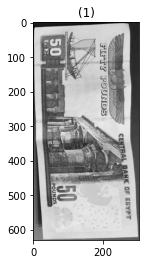

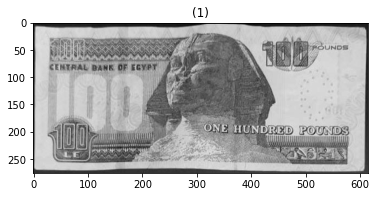

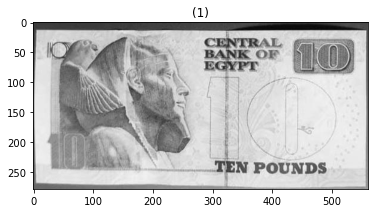

In [90]:
#TO TEST THE PIPELINE

motion_imgs_path = r'Segmented'
fns = os.listdir(motion_imgs_path)
fns = sorted(fns)
images = []
for fn in fns:
    img_path = os.path.join(motion_imgs_path, fn)
    im = cv.imread(img_path,0)
    # im=rgb2gray(im)
    images.append(im)   


filtered_img_own_testing=[]
for img in(images):


    note2=np.copy(img)
#     print(note2.shape)
#     
#     filtered_img_own_testing.append( cv.bilateralFilter(note2, 5, 20.0, 10.0) ) 
    filtered_img_own_testing.append(bilateral_filter_own(note2, 5, 12.0, 16.0))
    show_images([note2])



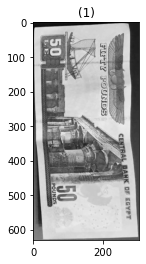

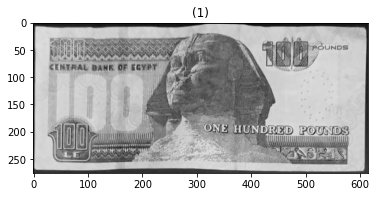

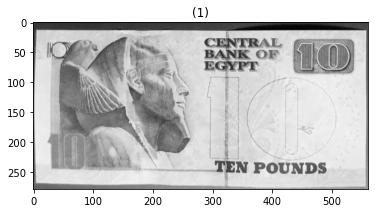

In [91]:
cl1=[]

for i in range(0,len(filtered_img_own_testing)):

#     filtered_image_own[i] = cv.resize(filtered_image_own[i], (0, 0), fx=0.1, fy=0.1)
#     filtered_img_own_testing[i]=rgb2gray(filtered_img_own_testing[i])
    filtered_img_own_testing[i]=np.array(filtered_img_own_testing[i],dtype='uint8')
#     clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     cl1.append(clahe.apply(filtered_img_own_testing[i]))
    c=imgContraster()
    cl1.append(c.enhance_contrast(filtered_img_own_testing[i], method = "CLAHE", blocks = 8, threshold = 2.0))
    show_images([filtered_img_own_testing[i]])
#     show_images([filtered_img_own_test[i]])

In [92]:
# Loading the Model
filename='final_model.sav'
data = pickle.load(open(filename, 'rb'))
clf=data[0]
voc=data[1]

featurestest=[]

print(type(cl1))    
for i in range(len(cl1)):
    cl1[i]=np.array(cl1[i])
    
    cl1[i]=rgb2gray(cl1[i])

    if(cl1[i].shape[0]>cl1[i].shape[1]):
        
        width = 150
        height = 350
        
    else:
        width = 350
        height = 150
        
    dim = (width, height)    
    cl1[i] = cv.resize(cl1[i], dim)

    
    print("image no:",i)
    imgg=cl1[i]
#     imgg=rgb2gray(imgg)
    
    feats=[]
    sift_detector = SIFT(imgg)
    feats = sift_detector.get_features()
    

    octave1=feats[0].shape[0]
    octave2=feats[1].shape[0]
    octave3=feats[2].shape[0]
    octave4=feats[3].shape[0]


    descriptors=[]
    feats=np.array(feats)
    descriptors[0:octave1-1]=feats[0]
    descriptors[octave1:octave1+octave2-1]=feats[1]
    descriptors[octave1+octave2:octave1+octave2+octave3-1]=feats[2]
    descriptors[octave1+octave2+octave3:octave1+octave2+octave3+octave4-1]=feats[3]
    
    dist=scipy.spatial.distance.cdist(descriptors,voc,'euclidean')
    
    bin_assignment=np.argmin(dist,axis=1)
    
    image_feats=np.zeros(67693)
    for id_assign in bin_assignment:
        image_feats[id_assign]+=1
        
    featurestest.append(image_feats)
    
featurestest=np.array(featurestest)
features_norm_div=np.linalg.norm(featurestest,axis=1)
for i in range(0,featurestest.shape[0]):
    featurestest[i]=featurestest[i]/features_norm_div[i]
    

print(featurestest.shape)

<class 'list'>
image no: 0
image no: 1
image no: 2
(3, 67693)


In [93]:
y_predict=clf.predict(featurestest)
# print(y_predict)
y_predict[y_predict==6]=5
y_predict[y_predict==11]=10
y_predict[y_predict==21]=20
y_predict[y_predict==51]=50
y_predict[y_predict==101]=100
y_predict[y_predict==201]=200
print("-----------------------------------------")
print(y_predict)

# print(y_test)

# s=(y_predict==y_test)
# acc=sum(s==True)/len(y_predict)
# print(acc*100)

-----------------------------------------
[ 50 100  10]
